<a href="https://colab.research.google.com/github/tlysenko/KyivstarBigDataSchool-studies/blob/master/Task_Finding_insights_in_log_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Downloading the data

In [0]:
#Mounting GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# user.csv
df_usr = pd.read_csv('/content/drive/My Drive/Datasets/exam/files/performance-issue/users.csv', sep = ',', header= None)
df_usr.columns = ['usr_id', 'comp_id', 'comp_name']

In [0]:
# performance.csv
all_lines=[]
with open("/content/drive/My Drive/Datasets/exam/files/performance-issue/performance.csv") as f:
  for line in f:
    line = line.split(',')
    
    new_line = [pd.Timestamp(line[0]).to_pydatetime(), \
                int(line[1]), \
                int(line[2]), \
                str(line[3]), \
                str(line[4]), \
                str(line[5].split('\n')[0])]
    all_lines.append(new_line)

df_pr = pd.DataFrame(all_lines)
df_pr.columns = ['time_stamp','proc_time', 'response_code', 'request_type', 'request_uri','usr_id']

# Exploratory Data Analysis

## Genreal information: file users.csv

In [0]:
df_usr.head()

,usr_id,comp_id,comp_name
0,1,1,company_1
1,2,1,company_1
2,4,1,company_1
3,5,1,company_1
4,11,6,company_6


In [0]:
#Number of users
len(set(df_usr['usr_id']))

62429

In [0]:
#Number of companies
len(set(df_usr['comp_id'])) , len(set(df_usr['comp_id']))

(19053, 19053)

## General information: file performance.csv

In [0]:
df_pr.shape

(9514094, 6)

In [0]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9514094 entries, 0 to 9514093
Data columns (total 6 columns):
time_stamp       datetime64[ns]
proc_time        int64
response_code    int64
request_type     object
request_uri      object
usr_id           object
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 435.5+ MB


## Understanding the response codes

In [0]:
# Response codes, absolute values
df_pr['response_code'].value_counts()

200    8933017
401     294647
404     100645
302     100419
304      51295
403      19832
400       4473
409       3767
405       2231
406       2209
500       1265
204        268
416         26
Name: response_code, dtype: int64

In [0]:
# Response code, percentages from total
df_pr['response_code'].value_counts()/df_pr.shape[0]

200    0.938925
401    0.030970
404    0.010579
302    0.010555
304    0.005391
403    0.002084
400    0.000470
409    0.000396
405    0.000234
406    0.000232
500    0.000133
204    0.000028
416    0.000003
Name: response_code, dtype: float64

* 200: The server successfully processed the request and is not returning any content
* 401: Unauthorized Error
* 404: Page not found
* 302: resource requested has been temporarily moved to the URL given by the Location header.
* 304: Not Modified.
* 403: Request forbidden
* 204: No content
* 400: Bad Request response status code 
* 500: internal server error

## Understanding processing time delays

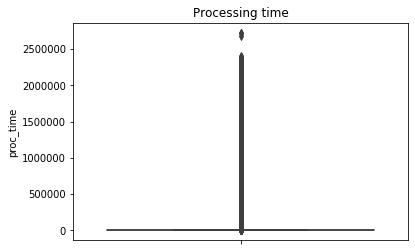

In [0]:
sns.boxplot(data=df_pr, y = 'proc_time');
plt.title('Processing time');

Processing time looks healthy for the vast majority of the cases. Let's see where the delays took place. 

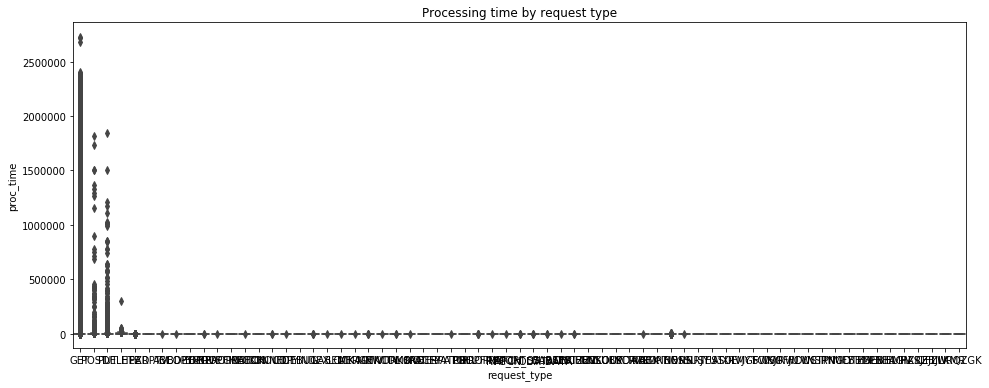

In [0]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_pr, \
            y = 'proc_time', x = 'request_type');
plt.title("Processing time by request type");

We can see that there are top 4 request types that are causing major delays. Let's loook at them closer. 

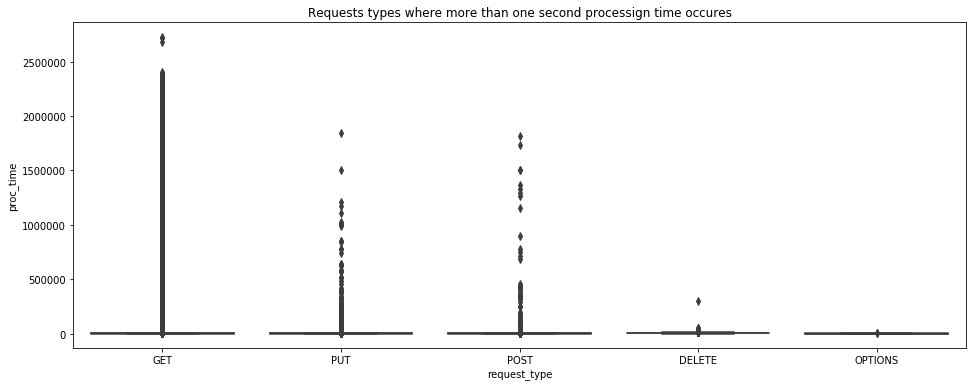

In [0]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_pr.loc[df_pr['proc_time']>1000, :], \
            y = 'proc_time', x = 'request_type');
plt.title("Requests types where more than one second processign time occures");

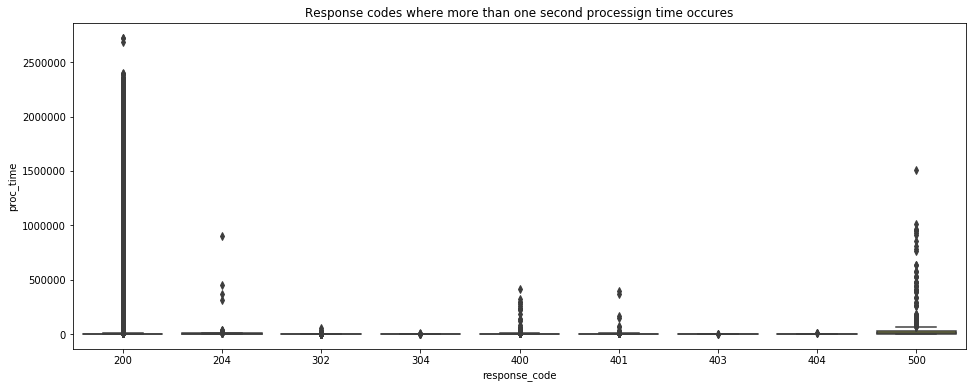

In [0]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_pr.loc[df_pr['proc_time']>1000, :], \
            y = 'proc_time', x = 'response_code');
plt.title("Response codes where more than one second processign time occures");

* 200: The server successfully processed the request and is not returning any content
* 204: No content
* 500: internal server error
* 400: Bad Request response status code 
* 401: Unauthorized Error

* 404: Page not found
* 302: resource requested has been temporarily moved to the URL given by the Location header.
* 304: Not Modified.
* 403: Request forbidden


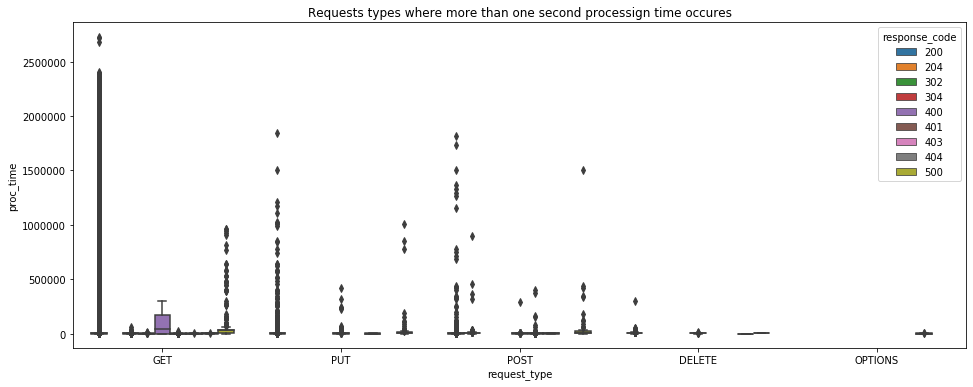

In [0]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_pr.loc[df_pr['proc_time']>1000, :], \
            y = 'proc_time', x = 'request_type', hue = 'response_code');
plt.title("Requests types per response code where processing time is > 1 sec");

## Understanding the period of the events

In [0]:
min(df_pr['time_stamp']), max(df_pr['time_stamp'])

(Timestamp('2017-08-01 00:04:33.004000'),
 Timestamp('2017-10-04 23:59:59.410000'))

All events are happening in 2017 in the months of August, September and first 4 days of October.

## Understanding weekly sesonality 

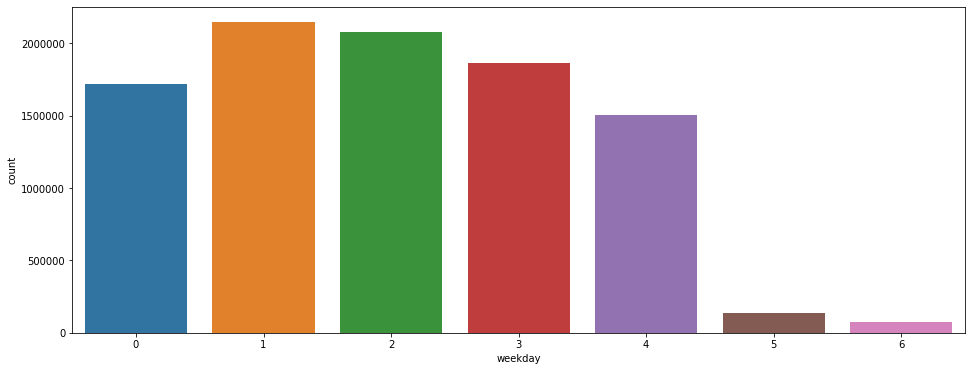

In [0]:
# Amount of request per week day
df_pr['weekday'] = [x.weekday() for x in df_pr['time_stamp']]
plt.figure(figsize=(16, 6))
sns.countplot(df_pr['weekday']);

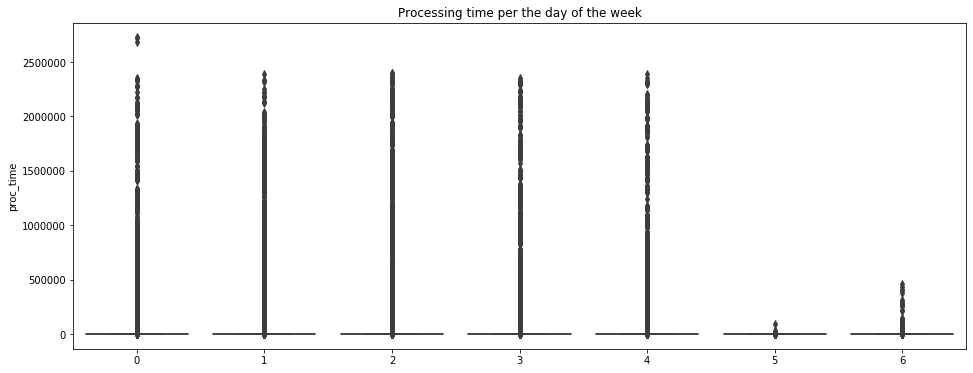

In [0]:
plt.figure(figsize=(16, 6))
x = df_pr['weekday']
y = df_pr['proc_time']

sns.boxplot(x,y);
plt.title("Processing time per the day of the week");

Company offers CRM service solution that is mainly used during the working days. Even though delays in using the service are happening during the weekends.

## Which service links are causing more then 200 ms delays and what are their response codes? 

In [0]:
# Counting amount of 1sec+ response time requests
dd = df_pr.loc[ df_pr.proc_time > 1000, :]
dd = dd.groupby('request_uri')['response_code'].value_counts()
dd.sort_values(ascending=False)[:20]

request_uri                                                response_code
/api/rest/search/clients                                   200              104840
/api/rest/search/individuals                               200              104407
/api/rest/lenders/{}/tpos/{}/docmanagement                 200               55077
/api/rest/lenders/{}/channel-summary                       200               46263
/api/rest/lenders/{}/applications                          200               38538
/api/rest/lenders/{}/clients                               200               38378
/api/rest/login                                            200               33669
/api/rest/lenders/{}/tpos/{}/docmanagement/{}/tpodocument  200               33014
/api/rest/tpos/{}/company-information                      200               27642
/api/rest/lenders/{}/channels/tpos/{}/accessible           200               26944
/api/rest/lenders/{}/channels                              200               20726
/api/rest/orga

## Is there any particular user or company causing too much load ? 

### Top users causing the hightes amount of requests with more than 1 sec delay in response time 

In [0]:
# Users causing highest amount of requests with more than 1 second response time
du = df_pr.loc[ df_pr.proc_time > 1000, :]
du = du.groupby('usr_id')['response_code'].value_counts()
du.sort_values(ascending=False)[:20]

usr_id  response_code
        200              42325
asc     200              40579
67325   200              14840
49197   200              14141
50312   200              13386
17120   200              12413
64702   200              12185
66490   200              11941
51601   200              11312
66075   200              11184
67326   200              11005
67328   200              10488
69073   200               9643
39912   200               9588
67324   200               9577
66392   200               9529
68533   200               8822
58391   200               8580
41826   200               8133
65760   200               8032
Name: response_code, dtype: int64

#### Companies causing highest amount of requests with more than 1 second response time


In [0]:
comp  = []
print('UserId Company name')
for usr in [x[0] for x in tt.index]:
  if usr!='' and usr!='asc':
    company_name = df_usr.loc[df_usr.usr_id == int(usr) , 'comp_name'].values[0]
    print(usr, company_name)
    comp.append(company_name)

UserId Company name
67325 company_208
49197 company_2251
50312 company_3684
17120 company_5826
64702 company_14634
66490 company_1
51601 company_1
66075 company_8931
67326 company_208
67328 company_208
69073 company_14634
39912 company_3684
67324 company_208
66392 company_1
68533 company_46541
58391 company_41983
41826 company_34733
65760 company_43396


### List of companies experiencing the highes amount of requests with delays

In [0]:
pd.Series(comp).value_counts()

company_208      4
company_1        3
company_3684     2
company_14634    2
company_8931     1
company_46541    1
company_41983    1
company_34733    1
company_5826     1
company_2251     1
company_43396    1
dtype: int64